# (13) Fit -- cuda1

**Motivation**: Fitting notebook, cuda1 <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from analysis.opticflow import *
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

## Trainer

In [2]:
vae = VAE(ConfigVAE(
    'fixate1', n_enc_cells=2, n_dec_cells=2, n_enc_nodes=2, n_dec_nodes=1,              
    n_latent_scales=3, n_groups_per_scale=12, n_latent_per_group=20,
))
tr = TrainerVAE(
    model=vae,
    cfg=ConfigTrainVAE(
        lr=0.0005, batch_size=500, epochs=150, grad_clip=500,
        warm_restart=1, warmup_portion=0.02,
        lambda_anneal=True, lambda_init=1e-7, lambda_norm=1e-3, 
        kl_beta=0.10, kl_anneal_cycles=0, kl_anneal_portion=0.5, kl_const_portion=1e-4),
    device='cuda:1',
)
vae.cfg.total_latents()

420

In [3]:
sum(vae.ftr_sizes()[0].values())

5056

In [4]:
vae.print()
vae.scales

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  25.5 Mil  |
|     ---      |    ---     |
|     stem     |    320     |
| pre_process  |   96.0 K   |
|  enc_tower   |  13.9 Mil  |
|     enc0     |   66.0 K   |
| enc_sampler  |  2.6 Mil   |
| dec_sampler  |  2.5 Mil   |
|    expand    |  351.2 K   |
|  dec_tower   |  5.9 Mil   |
| post_process |   40.0 K   |
|     out      |    578     |
+--------------+------------+

[8, 4, 2]

In [5]:
len(vae.all_conv_layers), len(vae.all_log_norm)

(218, 173)

## Review train options

In [6]:
print(f"{vae.cfg.name()}\n{tr.cfg.name()}")

fixate1_k-32_z-20x[3,6,12]_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)
ep150-b500-lr(0.0005)_beta(0.1:0x0.5)_lamb(0.001)_gr(500)

In [7]:
print({
    k: v for k, v in vars(vae.cfg).items() if
    all(e not in k for e in ['useful', 'dir', 'path', 'file'])
})

{
    'sim': 'fixate1',
    'n_ch': 32,
    'ker_sz': 2,
    'input_sz': 17,
    'n_enc_cells': 2,
    'n_enc_nodes': 2,
    'n_dec_cells': 2,
    'n_dec_nodes': 1,
    'n_pre_cells': 3,
    'n_pre_blocks': 1,
    'n_post_cells': 3,
    'n_post_blocks': 1,
    'n_latent_scales': 3,
    'n_latent_per_group': 20,
    'n_groups_per_scale': 12,
    'spectral_norm': 0,
    'separable': False,
    'compress': True,
    'use_bn': False,
    'groups': [12, 6, 3],
    'seed': 0,
    'balanced_recon': True,
    'activation_fn': 'swish',
    'residual_kl': True,
    'scale_init': False,
    'ada_groups': True,
    'use_se': True
}

In [8]:
print(vars(tr.cfg))

{
    'lr': 0.0005,
    'epochs': 150,
    'batch_size': 500,
    'warm_restart': 1,
    'warmup_portion': 0.02,
    'optimizer': 'adamax_fast',
    'optimizer_kws': {'betas': (0.9, 0.999), 'weight_decay': 0.0003, 'eps': 1e-08},
    'scheduler_type': 'cosine',
    'scheduler_kws': {'T_max': 49.0, 'eta_min': 1e-05},
    'ema_rate': 0.999,
    'grad_clip': 500,
    'chkpt_freq': 5,
    'eval_freq': 2,
    'log_freq': 10,
    'use_amp': False,
    'kl_beta': 0.1,
    'kl_beta_min': 0.0001,
    'kl_balancer': 'equal',
    'kl_anneal_cycles': 0,
    'kl_anneal_portion': 0.5,
    'kl_const_portion': 0.0001,
    'lambda_anneal': True,
    'lambda_init': 1e-07,
    'lambda_norm': 0.001,
    'spectral_reg': False
}

## Train

In [9]:
comment = f"Deep_{tr.cfg.name()}"
tr.train(comment=comment)

gstep # 9.67e+03, nelbo: 4.867, grad: 171.8:   5%|▌         | 8/150 [1:36:33<28:25:10, 720.50s/it]

In [ ]:
tr.validate(gstep=8*len(tr.dl_trn))

## Eval

In [9]:
%%time

val, loss = tr.validate(use_ema=False)
val_ema, loss_ema = tr.validate(use_ema=True)

CPU times: user 2min 42s, sys: 43 s, total: 3min 25s
Wall time: 17min 19s


In [10]:
loss_summary = {
    k: {
        'vae': np.round(v.mean(), 2),
        'ema': np.round(loss_ema[k].mean(), 2),
    } for k, v in loss.items()
}
print(f"{vae.cfg.name()}\n{tr.cfg.name()}\n\n{loss_summary}\n")

fixate2_k-32_z-20x[2,4,8]_enc(1x3)-dec(1x2)-pre(1x3)-post(1x3)
ep400-b1000-lr(0.004)_beta(0.2:1x0.3)_lamb(0.0001)_gr(1000)

{'epe': {'vae': 3.79, 'ema': 3.8}, 'kl': {'vae': 41.86, 'ema': 41.85}}

fig/sample (VAE)

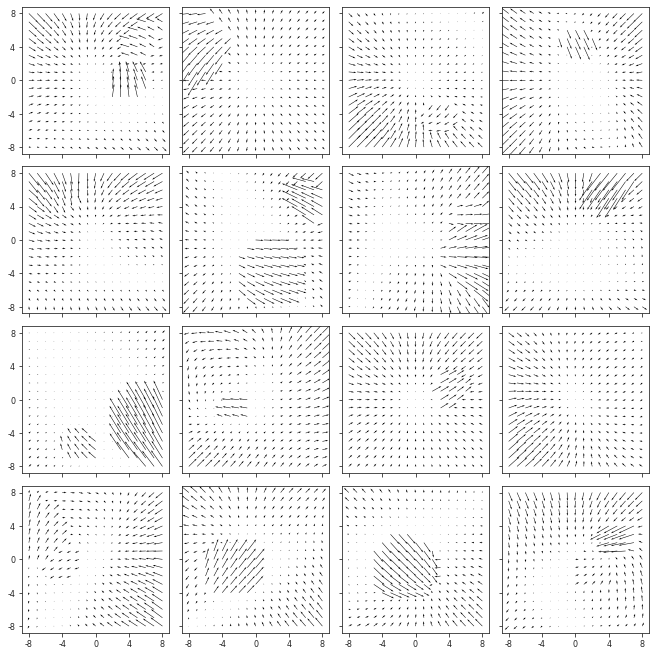

fig/sample (EMA)

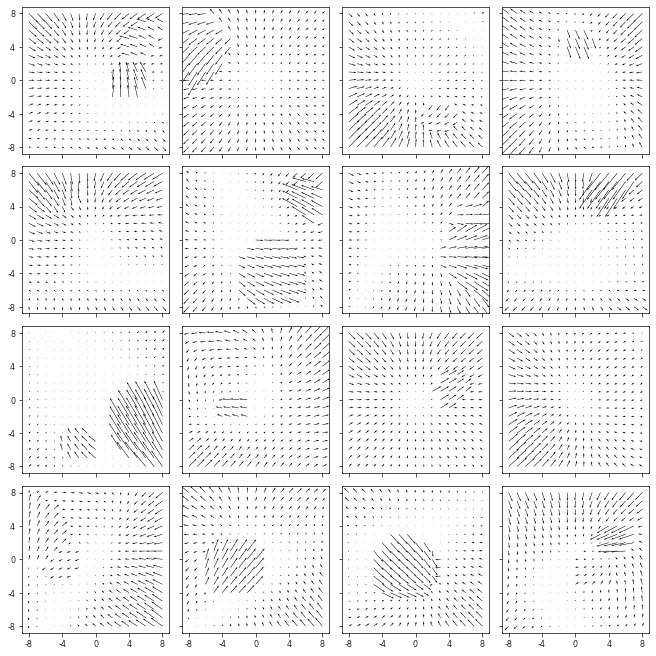

----------------------------------------------------------------------

fig/regression (VAE)

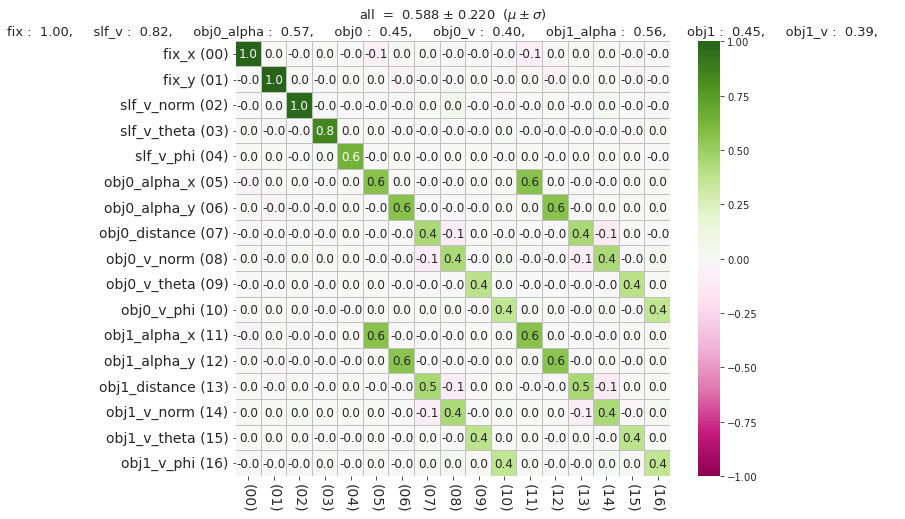

fig/regression (EMA)

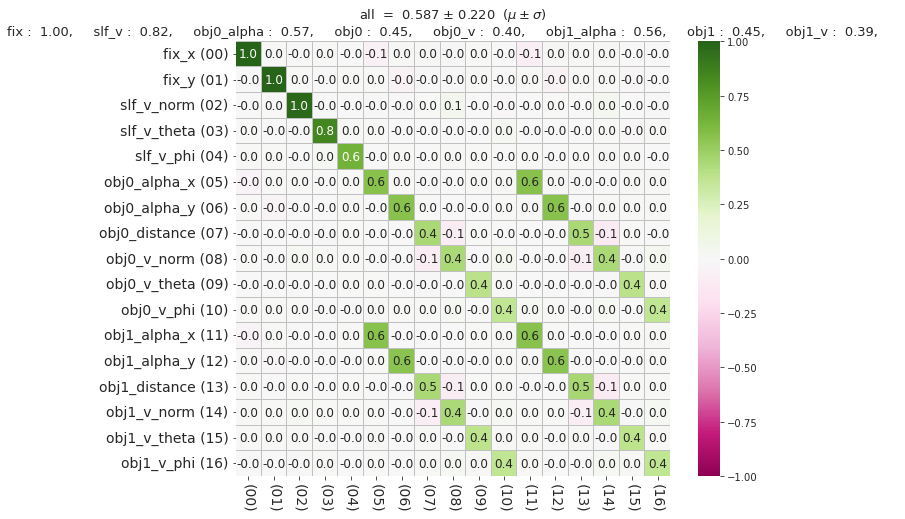

----------------------------------------------------------------------

fig/bar (VAE)

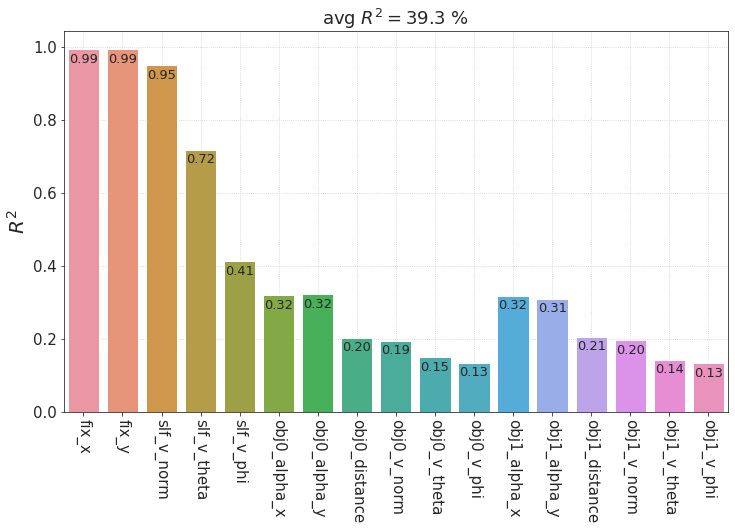

fig/bar (EMA)

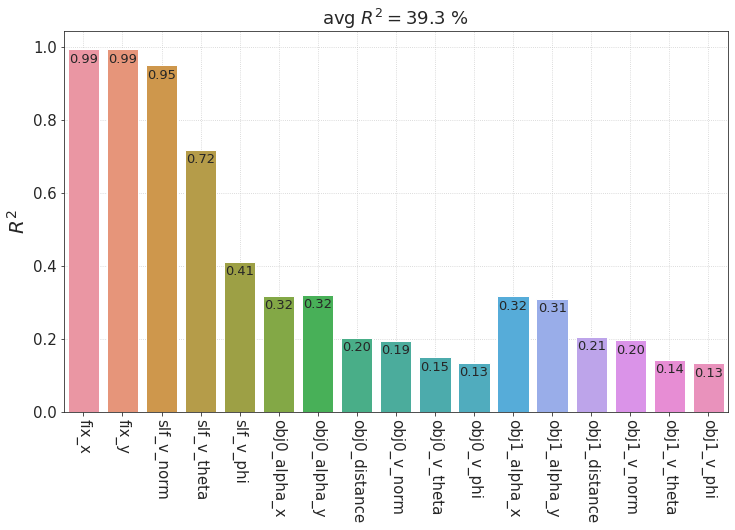

----------------------------------------------------------------------

fig/bar_aux (VAE)

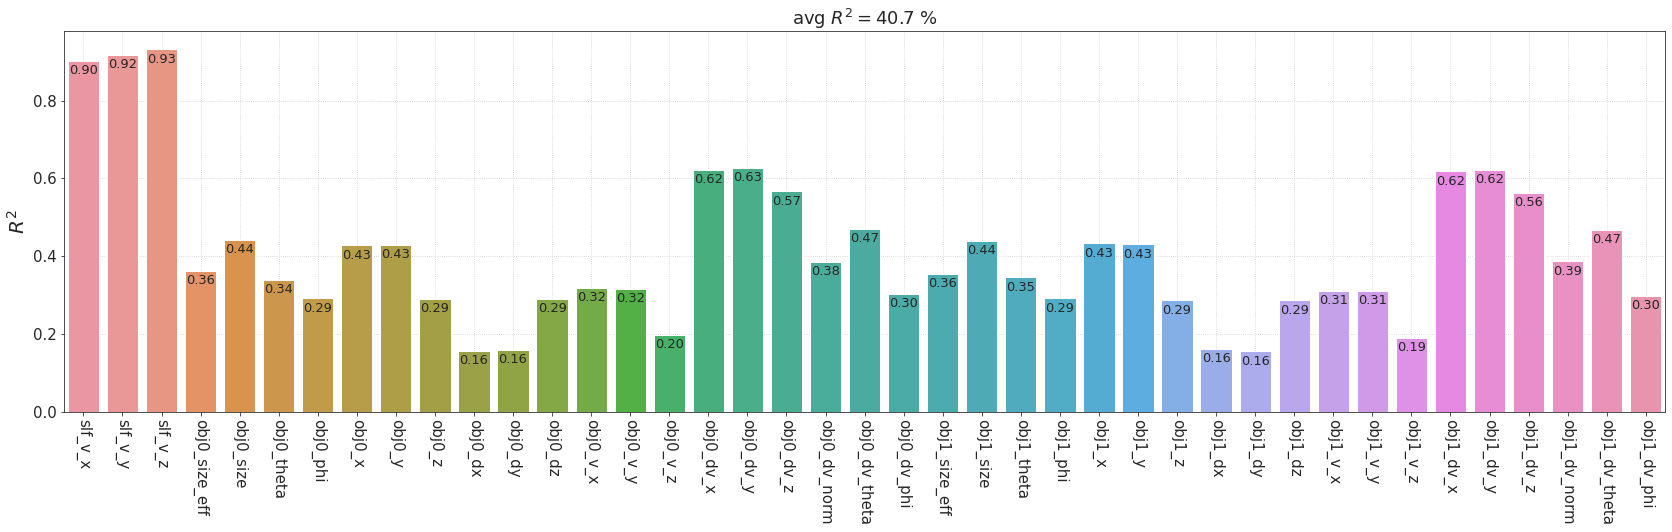

fig/bar_aux (EMA)

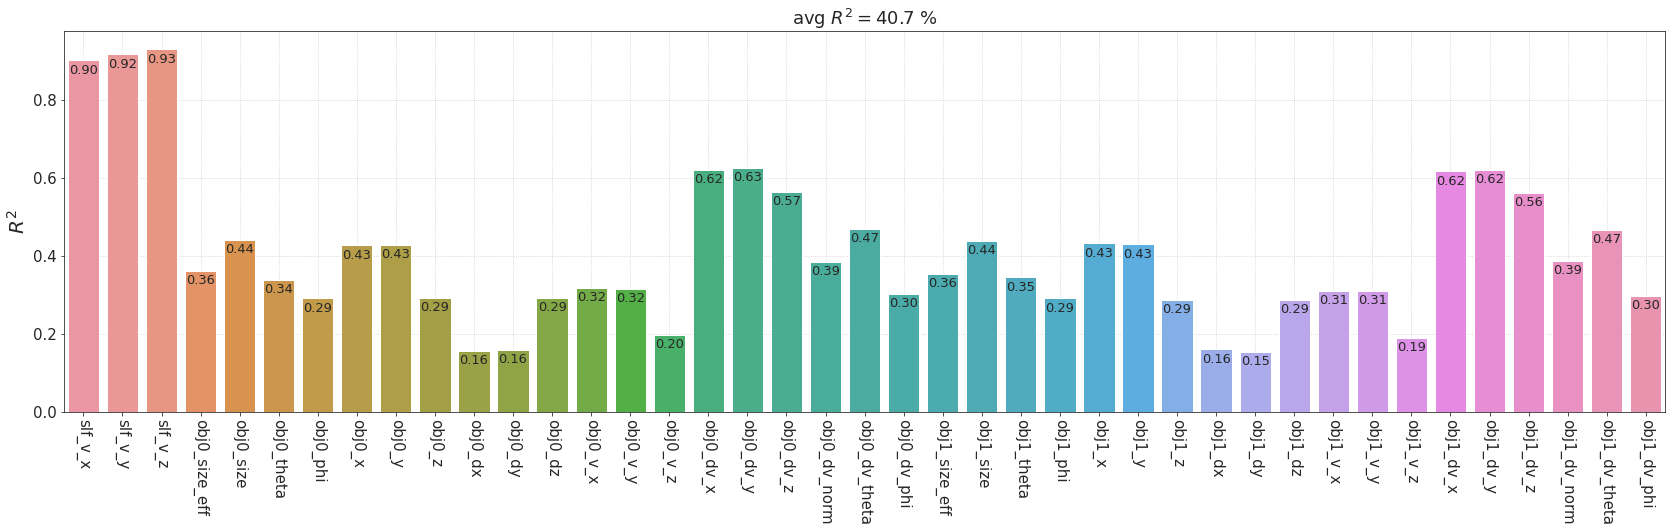

----------------------------------------------------------------------

fig/mutual_info (VAE)

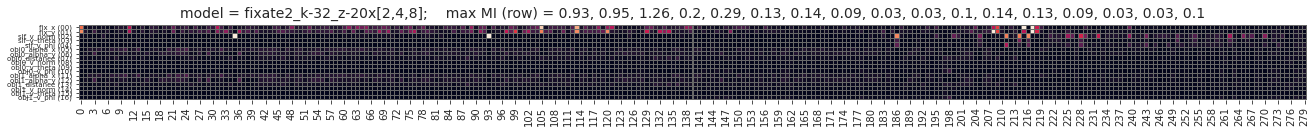

fig/mutual_info (EMA)

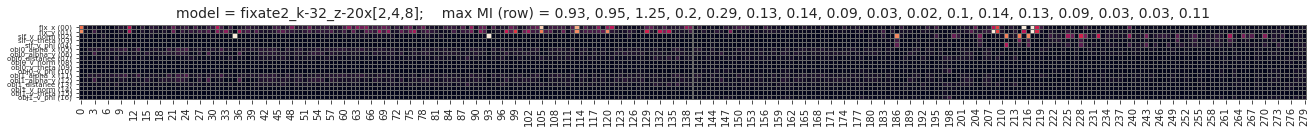

----------------------------------------------------------------------

In [11]:
for k, v in val.items():
    if 'fig' in k:
        print(f"{k} (VAE)")
        display(v)
        print(f"{k} (EMA)")
        display(val_ema[k])
        print('-' * 70)

In [12]:
len(tr.stats['grad'])

182

In [14]:
np.quantile(tr.stats['grad'], [0.5, 0.7, 0.9, 1])

array([5.99852881e+03, 3.31414691e+04, 6.06242619e+05, 3.20467665e+11])

In [15]:
np.quantile(tr.stats['loss'], [0.5, 0.7, 0.9, 1])

array([1.83597097e+01, 3.33677979e+01, 1.99485512e+02, 5.41584938e+05])

In [16]:
gamma = np.stack(tr.stats['gamma'])
gamma.shape

(160000, 30)

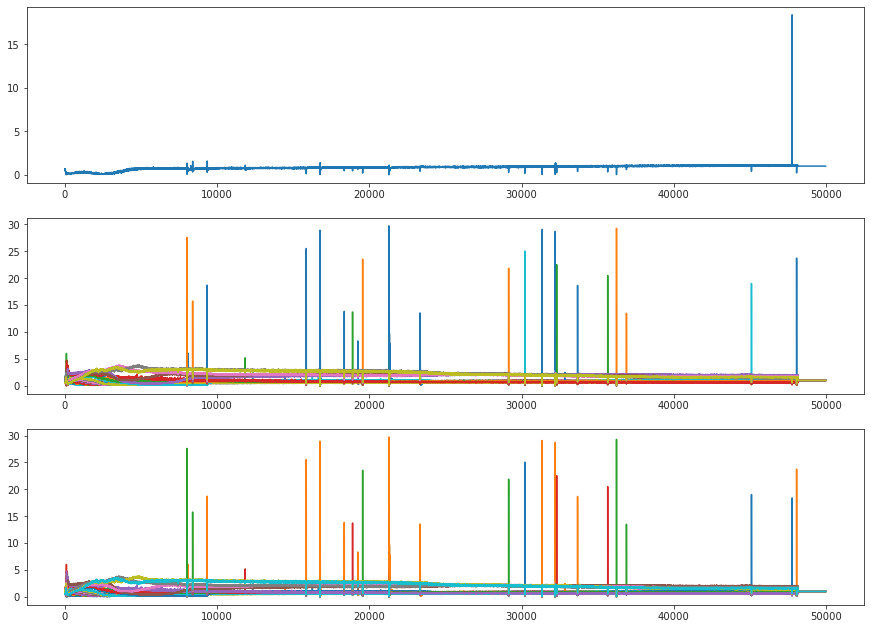

In [17]:
fig, axes = create_figure(3, 1, (15, 11))
axes[0].plot(gamma[:50000, 0])
axes[1].plot(gamma[:50000, 1:])
axes[2].plot(gamma[:50000]);